In [125]:
import json
import nltk

# tokenizing
from nltk import word_tokenize


#stop-words
from nltk.corpus import stopwords
stop_words=set(nltk.corpus.stopwords.words('english'))


#word2vec
from gensim.models import Word2Vec  

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


with open('data.json') as json_file:      
    data_r = json.load(json_file)

In [126]:
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [127]:
ids = [w['id'] for w in data_r]
print(data_r[-1]['created_utc'])
if len(ids) == len(set(ids)):
    print("Your data contains no repeated submissions")

1552710953.0
Your data contains no repeated submissions


In [128]:
def transform(label):
    max = 0
    new_label = ""
    for k, v in label.items():
        if v >= max:
            
            max = v
            new_label = k
    return new_label


In [129]:
def balance(n):  
    counter = n
    for i, w in enumerate(data_r):
        if w['label'] == 'NTA' and counter>0:
            del data_r[i]
            counter-=1

    print(len(data_r))

In [130]:
for w in data_r:
    if type(w['label'])==type({}):
        w['label'] = transform(w['label'])
balance(6000)
print(len(data_r))
allDone()

32100
32100


In [131]:
ids = np.array([w['id'] for w in data_r if w['label']!= None])
titles = np.array([w['title'] for w in data_r if w['label']!= None])
bodies = np.array([w['selftext'] for w in data_r if w['label']!= None])
labels = np.array([w['label'] for w in data_r if w['label'] != None])

print(titles.shape)
print(labels.shape)

(22848,)
(22848,)


In [132]:
data = np.vstack([titles,labels, bodies])
data = np.vstack([ids, data])

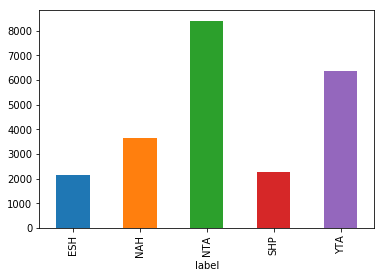

In [133]:
datas = pd.DataFrame(data=data.T, columns = ['id', 'title', 'label', 'bodies'])
datas.set_index('id')
datas[400:410]
datas.groupby("label")['id'].count().plot.bar()

In [134]:
from sklearn.model_selection import train_test_split
def split(inputs, labels):
    title, title_t, label, label_t = train_test_split(inputs, labels)
    title_tr, title_v, label_tr, label_v= train_test_split(title, label)
    
    return title, title_t, title_tr, title_v, label, label_t, label_tr, label_v

In [135]:
from imblearn.over_sampling import ADASYN
def oversample(value, label):
    sme = ADASYN()
    print('First sme')
    X_res, y_res = sme.fit_resample(value, label)
    print('First sme done')
    return X_res, y_res

In [136]:
from imblearn.under_sampling import ClusterCentroids
from collections import Counter
def undersample(value, label):


    label_counts = Counter(label_v)
    count = label_counts.most_common()
    
    
    classes= {'NTA':4*count[-1][1], 'YTA':count[-4][1], 'ESH':count[-1][1], 'SHP':count[-2][1], 'NAH':count[-3][1]}
    cc = ClusterCentroids(random_state=13, sampling_strategy=classes)
    X_res, y_res = cc.fit_resample(value, label)
    print('First sme done')
    return X_res, y_res

In [137]:
title, title_t, title_tr, title_v, label, label_t, label_tr, label_v = split(titles, labels)

In [138]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def vectorize(title, title_t, title_tr, title_v):
    vectorizer = CountVectorizer()

    #With this I create a vectorizer and fit it on all questions
    vectorizer.fit(titles)
    #Here I transform the vectorizer with the specific questions, depending on if it will 
    #be used on the training, validation or all questions

    title_tr_en = vectorizer.transform(title_tr).toarray()
    title_v_en = vectorizer.transform(title_v).toarray()
    title_en = vectorizer.transform(title).toarray()
    title_t_en = vectorizer.transform(title_t).toarray()
    
    return vectorizer, title_en, title_t_en, title_tr_en, title_v_en

In [139]:
vectorizer, title_en, title_t_en, title_tr_en, title_v_en = vectorize(title, title_t, title_tr, title_v)
print(title_en.shape)
print(title_t_en.shape)
print(title_tr_en.shape)
print(title_v_en.shape)
print('Change')

(17136, 10471)
(5712, 10471)
(12852, 10471)
(4284, 10471)
Change


In [17]:
ori_val = [title_tr_en, title_en, title_v_en]
ori_lab = [label_tr, label, label_v]

title_tr_en, label_tr = undersample(ori_val[0], ori_lab[0])
title_en, label = undersample(ori_val[1], ori_lab[1])
title_v_en, label_v = undersample(ori_val[2], ori_lab[2])
allDone()

First sme done
First sme done


/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (384) found smaller than n_clusters (387). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (420) found smaller than n_clusters (426). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (1155) found smaller than n_clusters (1163). Possibly due to duplicate points in X.
  return_n_iter=True)


First sme done


In [140]:
from sklearn.ensemble import RandomForestClassifier

print(title_en.shape)
print(title_t_en.shape)
print(title_tr_en.shape)
print(title_v_en.shape)
#Here I create a Multinomial Naïve Bayes and train it on the training set
model = MultinomialNB()

#title_tr_en = abs(title_tr_en)
#model = RandomForestClassifier(n_estimators = 100)
model.fit(title_en, label)
allDone()

(17136, 10471)
(5712, 10471)
(12852, 10471)
(4284, 10471)


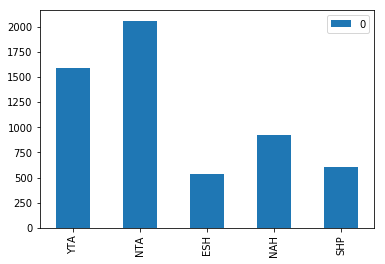

In [141]:
from collections import Counter

label_counts = Counter(label_t)
df = pd.DataFrame.from_dict(label_counts, orient='index')
df.plot(kind='bar')

In [142]:
from sklearn.metrics import precision_recall_fscore_support
from numpy import vstack

def RF_validate(value_tr_en, value_v_en, label_tr, label_v, model):
    precision_v = np.array([0, 0])
    recall_v = np.array([0, 0])
    f_v = np.array([0, 0])

    for i in range(1, 500, 20):
        model.set_params(n_estimators = i)
        model.fit(value_tr_en, label_tr)
        prediction = model.predict(value_v_en)
        test = precision_recall_fscore_support(label_v, prediction, average='macro')
        precision_v = vstack((precision_v, (i, test[0])))
        recall_v = vstack((recall_v, (i, test[1])))
        f_v = vstack((f_v, (i, test[2])))

    return [precision_v, recall_v, f_v]


In [143]:

#rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

from sklearn.metrics import precision_recall_fscore_support
from numpy import vstack

def NB_validate(value_tr_en, value_v_en, label_tr, label_v, model):
    precision_v = np.array([0, 0])
    recall_v = np.array([0, 0])
    f_v = np.array([0, 0])

    for i in range(0,11, 1):
        alpha = i/10
        model.set_params(alpha = alpha)
        model.fit(value_tr_en, label_tr)
        prediction = model.predict(value_v_en)
        test = precision_recall_fscore_support(label_v, prediction, average='macro')
        precision_v = vstack((precision_v, (alpha, test[0])))
        recall_v = vstack((recall_v, (alpha, test[1])))
        f_v = vstack((f_v, (alpha, test[2])))

    return [precision_v, recall_v, f_v]



In [144]:
def visualize_validation(measures):
    precision_v = measures[0]
    recall_v = measures[1]
    f_v = measures[2]
    x3 = precision_v[1:-1, 0]
    x1 = recall_v[1:, 0]
    x2 = f_v[1:-1, 0]

    y3 = precision_v[1:-1, 1]
    y1 = recall_v[1:, 1]
    y2 = f_v[1:-1, 1]

    # Create plots with pre-defined labels.
    fig, ax = plt.subplots()
    ax.plot(x1, y1, '.-', label='Recall')
    ax.plot(x2, y2, 'r--', label='F')
    ax.plot(x3, y3, 'o-', label='Precision')

    legend = ax.legend(fontsize='x-large')

    def npmax(y1, y2, y3):
        max_y = 0
        max_i = 0
        for i,y in enumerate(y1):
            y = 0.1*y + 0.1*y2[i-1] + 0.8*y3[i-1]
            if y > max_y:
                max_y = y
                max_i = i

        return (max_i, max_y)

    acc_i, acc_max = npmax(y1, y2, y3)
    max_alpha = x3[acc_i-1]
    
    return max_alpha

/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


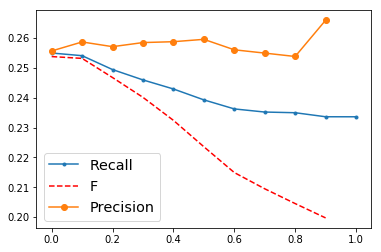

In [145]:

stats = NB_validate(title_tr_en, title_v_en, label_tr, label_v, model)
alpha = visualize_validation(stats)
allDone()

In [148]:
model.set_params(alpha = 0.2)
title_en = abs(title_en)
model.fit(title_en, label)

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)

In [149]:

pred_t = model.predict(title_t_en)

print(precision_recall_fscore_support(label_t, pred_t, average='macro'))
print(precision_recall_fscore_support(label_t, pred_t, average='micro'))


#print("Accuracy = " + str((tp+tn)/(len(y_test))))
#print("Precision = "+ str(tp/(tp+fp)))
#print("Recall = "+ str(tp/(tp+fn)))
#print("F1 = "+ str(2*tp/(2*tp+fp +fn)))
q = vectorizer.transform(['AITA for failing my students', 'AITA for hating C']).toarray()
print(model.predict(q))



(0.2661375628041971, 0.25581977603458245, 0.25484813291364083, None)
(0.3391106442577031, 0.3391106442577031, 0.3391106442577031, None)
['YTA' 'NTA']


In [150]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(label_t, model.predict(title_t_en))

measures_macro = list(precision_recall_fscore_support(label_t, model.predict(title_t_en), average='macro'))[:-1]
measures_micro = list(precision_recall_fscore_support(label_t, model.predict(title_t_en), average='micro'))[:-1]

In [151]:
cf_df = pd.DataFrame(cf, columns=['ESH', 'NAH', 'NTA', 'SHP', 'YTA'])
cf_df.rename(index={0:'ESH',1:'NAH',2:'NTA',3:'SHP',4:'YTA'}, inplace=True)
cf_df

,ESH,NAH,NTA,SHP,YTA
ESH,78,36,239,36,144
NAH,46,159,476,34,208
NTA,139,238,1156,96,430
SHP,47,76,296,56,129
YTA,126,199,676,104,488


In [152]:
measures_macro = ['macro'] + measures_macro
measures_micro = ['micro'] + measures_micro
measures_df = pd.DataFrame([measures_macro, measures_micro], columns=['Averaging', 'Precision', 'Recall', 'FScore'])
measures_df

,Averaging,Precision,Recall,FScore
0,macro,0.266138,0.255820,0.254848
1,micro,0.339111,0.339111,0.339111


In [ ]:
q = vectorizer.transform(['WIBTA if I put 250 slides in a lecture', 'AITA for starting a war', 'AITA for hating everyone']).toarray()
print(model.predict(q))

